In [1]:
import sys
import os
if colab := 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_PATH = '/content/drive/My Drive/machine-learning-project'
    sys.path.insert(0, BASE_PATH)
    N_JOBS = 1
    sys.path.insert(0, BASE_PATH + '/src/utils')
    !pip install optuna
    !pip install scikit-learn
    !pip install scikeras
    TRAIN_DATA = os.path.join(BASE_PATH, 'datasets', 'cup2023', 'ML-CUP23-TR.csv')
    IMAGES_DIR = os.path.join(BASE_PATH, 'images', 'cup2023', 'comparisons')
    MODELS_DIR = os.path.join(BASE_PATH, 'trained_models', 'cup2023')

else :
    N_JOBS = -1
    TRAIN_DATA = os.path.join('..', '..', 'datasets', 'cup2023', 'ML-CUP23-TR.csv')
    IMAGES_DIR = os.path.join('..', '..', 'images', 'cup2023', 'comparisons')
    MODELS_DIR = os.path.join('..', '..', 'trained_models', 'cup2023')

RF_MODEL = os.path.join(MODELS_DIR, 'random_forest_model.joblib')
SVM_MODEL = os.path.join(MODELS_DIR, 'SVR_model.joblib')
NN_GRID_MODEL = os.path.join(MODELS_DIR, 'NN_grid_model.joblib')
NN_OPTUNA_MODEL = os.path.join(MODELS_DIR, 'NN_model_Optuna_NN.joblib')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
if colab := 'google.colab' in sys.modules:
    sys.path.append(BASE_PATH + '/src/utils')
else:
    sys.path.append('../utils')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')

from utils import save_plot, mean_euclidean_error, root_mean_squared_error, multidim_r2, set_random_state, mean_squared_error

## Data processing

In [3]:
# To skip the first column (row indexes)
columns_to_read = list(range(1, 14))

df_train = pd.read_csv(TRAIN_DATA, header=None, comment='#', usecols=columns_to_read, delimiter=',')
df_train = df_train.astype('float64') # casting
df_train.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-0.917280,-0.712727,-0.989904,0.992819,0.993649,0.995543,0.711074,0.407645,-0.688548,0.616890,7.897453,-35.936382,21.077147
1,-0.858784,0.998755,-0.998396,0.999909,0.316503,-0.951897,-0.163139,0.980982,0.661759,-0.800155,-9.330632,19.901571,6.069154
2,-0.990441,0.958726,-0.998675,0.997216,0.987166,0.356483,-0.279689,0.599163,-0.684630,0.922901,14.849400,3.374090,19.667479
3,0.937117,0.984474,-0.612420,0.999812,0.728623,-0.539962,-0.165939,0.999352,-0.921444,-0.974766,-46.591854,13.734777,17.953600
4,-0.906628,-0.884567,-0.932487,0.941037,0.978134,0.998179,0.749606,-0.590599,-0.508268,0.691798,8.217500,-45.885254,14.894251


In [4]:
features = ['feature_' + str(i) for i in range(1, 11)]
targets = ['target_x', 'target_y', 'target_z']

# Rename columns
new_column_names = features + targets
df_train.columns = new_column_names

df_train.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,target_x,target_y,target_z
0,-0.917280,-0.712727,-0.989904,0.992819,0.993649,0.995543,0.711074,0.407645,-0.688548,0.616890,7.897453,-35.936382,21.077147
1,-0.858784,0.998755,-0.998396,0.999909,0.316503,-0.951897,-0.163139,0.980982,0.661759,-0.800155,-9.330632,19.901571,6.069154
2,-0.990441,0.958726,-0.998675,0.997216,0.987166,0.356483,-0.279689,0.599163,-0.684630,0.922901,14.849400,3.374090,19.667479
3,0.937117,0.984474,-0.612420,0.999812,0.728623,-0.539962,-0.165939,0.999352,-0.921444,-0.974766,-46.591854,13.734777,17.953600
4,-0.906628,-0.884567,-0.932487,0.941037,0.978134,0.998179,0.749606,-0.590599,-0.508268,0.691798,8.217500,-45.885254,14.894251


In [5]:
from sklearn.model_selection import train_test_split

X = df_train[features].to_numpy()
y = df_train[targets].to_numpy()

# Use seed 42 to have the same split we used in our models
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_test.shape

(200, 3)

In [6]:
from joblib import load

models = {
    'Support Vector Regressor': {'acronym': 'svr', 'model': load(SVM_MODEL)},
    'Random Forest': {'acronym': 'rf', 'model': load(RF_MODEL)},
    'Neural Network (Grid Search)': {'acronym': 'nn_grid', 'model': load(NN_GRID_MODEL)},
    'Neural Network (Optuna)': {'acronym': 'nn_optuna', 'model': load(NN_OPTUNA_MODEL)}
}

In [7]:
def ensemble_predict(ensemble, X_test):
    y_pred = np.zeros_like(y_test)
    for model in ensemble:
        y_pred += model.predict(X_test)
    y_pred /= len(ensemble)
    return y_pred

In [8]:
predictions = {}
for model_name, inner_dict in models.items():
    predictions[model_name] = ensemble_predict(inner_dict['model'], X_test)

7/7 [==============================] - 0s 6ms/step


## Individual coordinates scatter plot

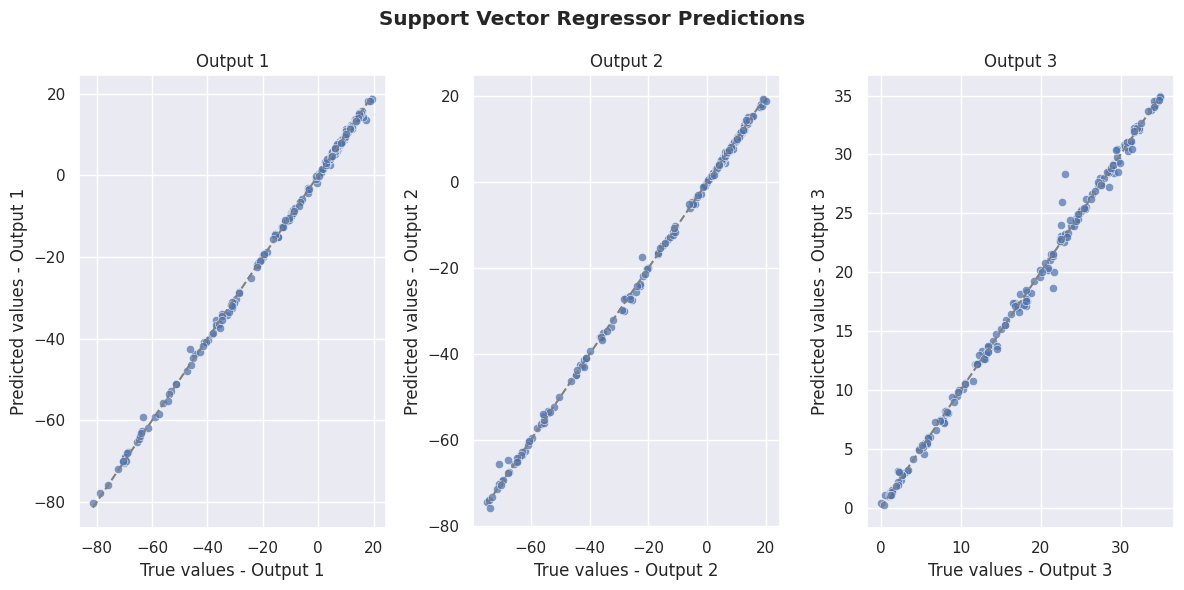

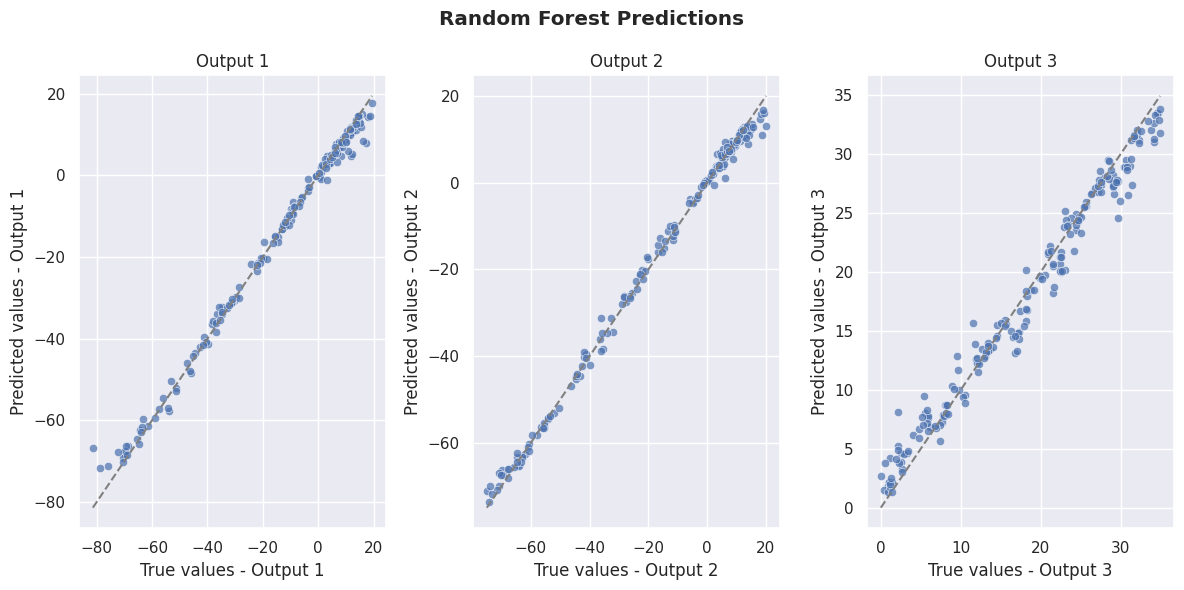

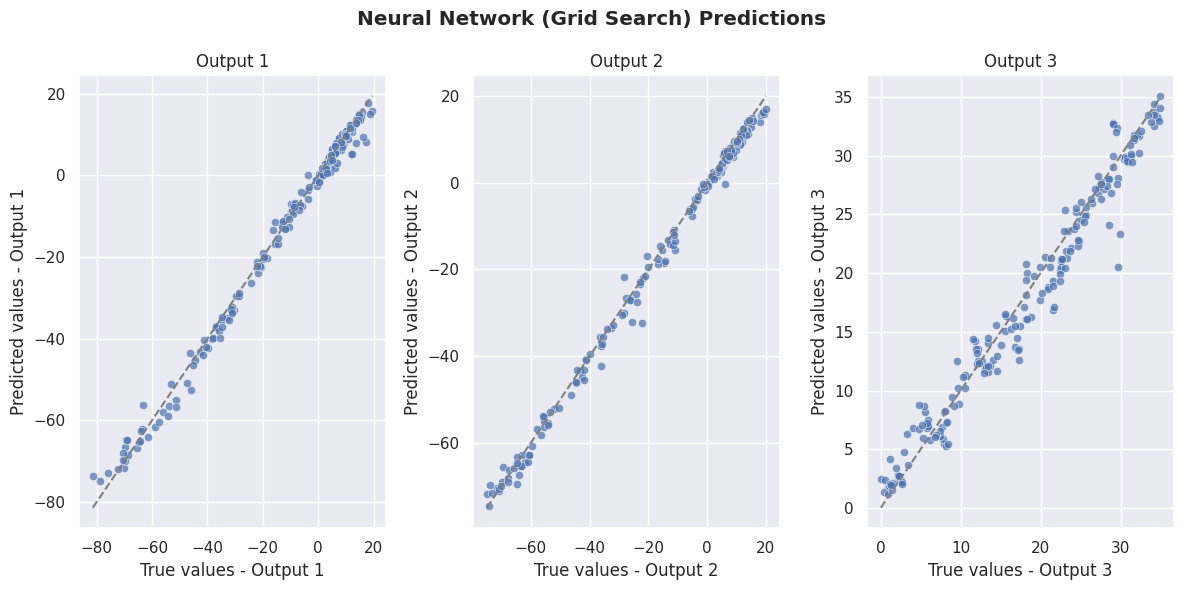

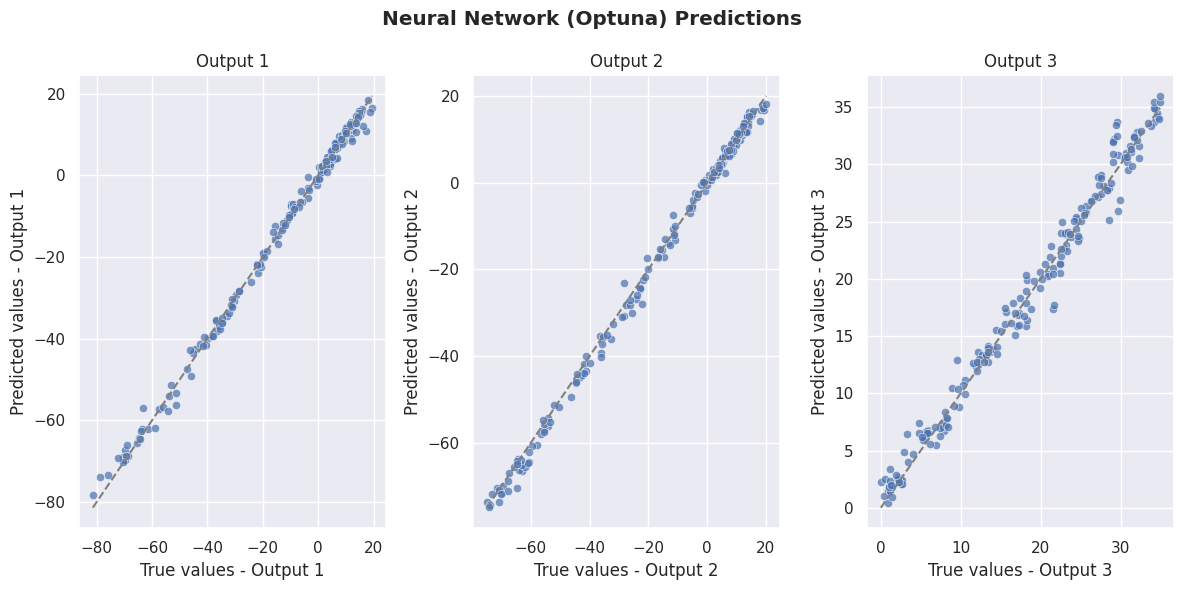

In [9]:
for model_name, prediction in predictions.items():
    plt.figure(figsize=(12, 6))

    for i in range(3):
        plt.subplot(1, 3, i + 1)
        sns.scatterplot(
            x=y_test[:, i],
            y=prediction[:, i],
            # label=model_name,
            marker='o',
            alpha=0.7
        )
        plt.plot(
            [min(y_test[:, i]), max(y_test[:, i])],
            [min(y_test[:, i]), max(y_test[:, i])],
            linestyle='--',
            color='gray'
        )

        plt.xlabel(f'True values - Output {i+1}')
        plt.ylabel(f'Predicted values - Output {i+1}')
        plt.title(f'Output {i+1}')

    plt.suptitle(f'{model_name} Predictions', fontweight='bold')
    plt.tight_layout()
    # plt.legend()
    model_acronym = models[model_name]['acronym']
    save_plot(plt, IMAGES_DIR, f'{model_acronym}_individual_coordinates_scatterplot')
    plt.show()

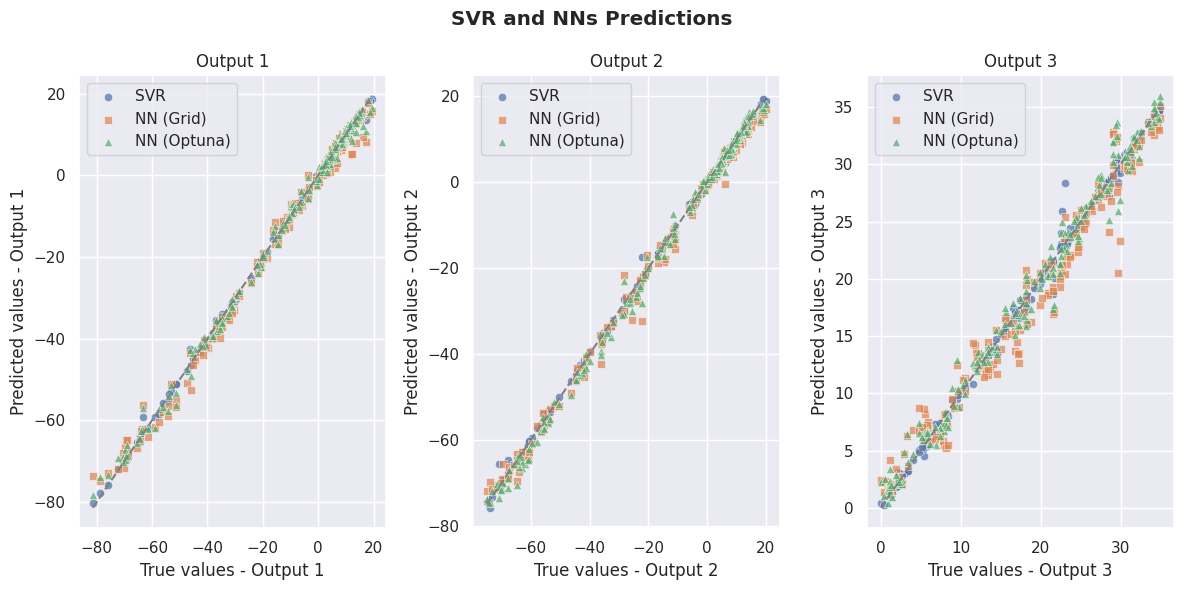

In [10]:
plt.figure(figsize=(12, 6))

for i in range(3):
    plt.subplot(1, 3, i + 1)
    sns.scatterplot(
        x=y_test[:, i],
        y=predictions['Support Vector Regressor'][:, i],
        label='SVR',
        marker='o',
        alpha=0.7
    )
    sns.scatterplot(
        x=y_test[:, i],
        y=predictions['Neural Network (Grid Search)'][:, i],
        label='NN (Grid)',
        marker='s',
        alpha=0.7
    )
    sns.scatterplot(
        x=y_test[:, i],
        y=predictions['Neural Network (Optuna)'][:, i],
        label='NN (Optuna)',
        marker='^',
        alpha=0.7
    )
    plt.plot(
        [min(y_test[:, i]), max(y_test[:, i])],
        [min(y_test[:, i]), max(y_test[:, i])],
        linestyle='--',
        color='gray'
    )

    plt.xlabel(f'True values - Output {i+1}')
    plt.ylabel(f'Predicted values - Output {i+1}')
    plt.title(f'Output {i+1}')

plt.suptitle(f'SVR and NNs Predictions', fontweight='bold')
plt.tight_layout()
plt.legend()
save_plot(plt, IMAGES_DIR, f'best3_individual_coordinates_scatterplot')
plt.show()

## Contributions to MEE

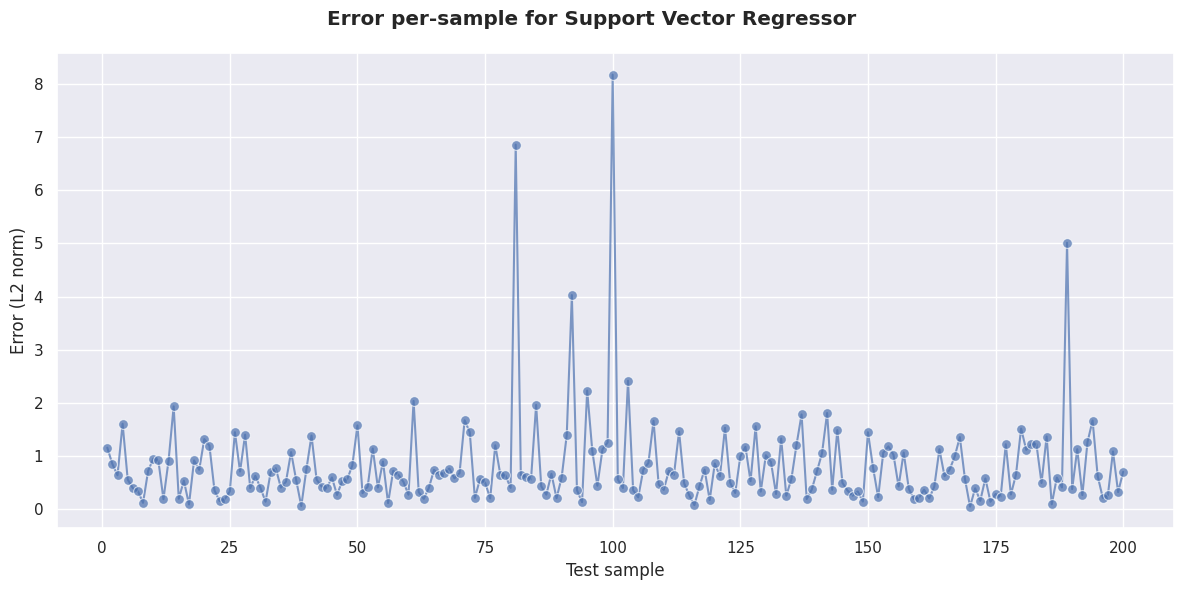

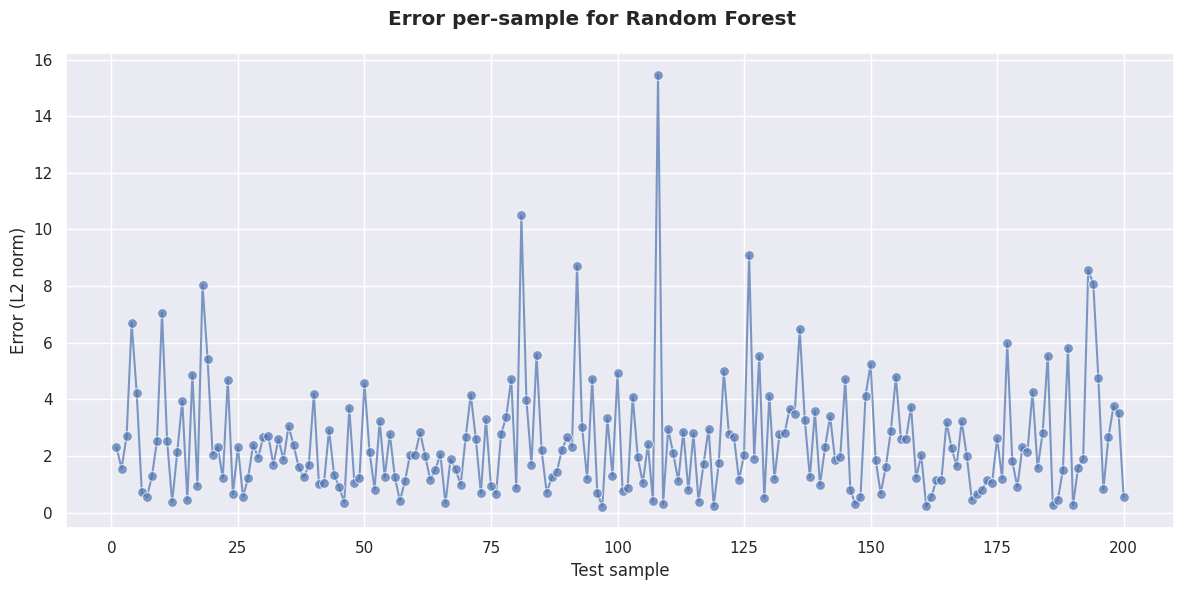

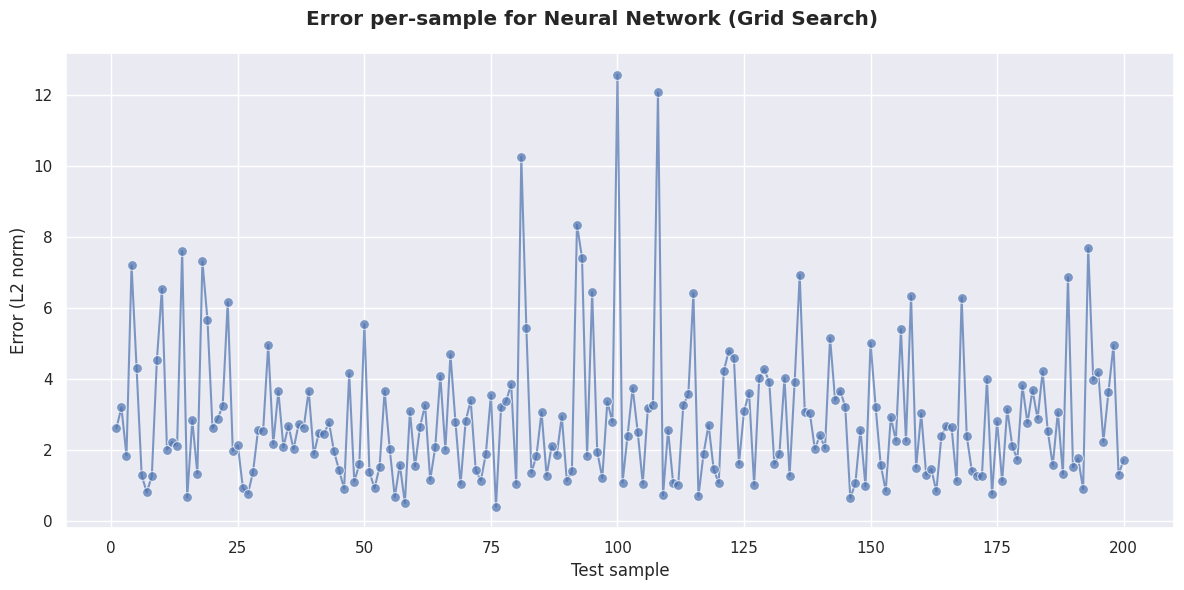

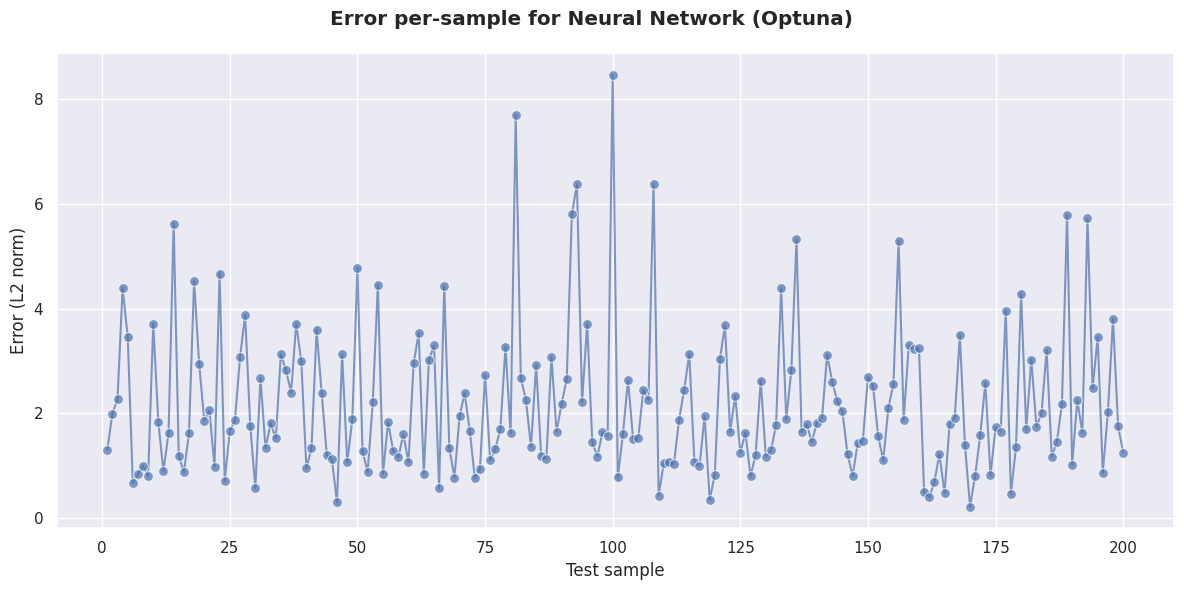

In [11]:
for model_name, prediction in predictions.items():
    plt.figure(figsize=(12, 6))

    sns.lineplot(
        x=range(1, y_test.shape[0] + 1),
        y=[np.linalg.norm((y_test - prediction)[i, :]) for i in range(y_test.shape[0])],
        # label=model_name,
        linestyle='-',
        marker='o',
        markersize=7,
        alpha=0.7
    )

    plt.xlabel('Test sample')
    plt.ylabel('Error (L2 norm)')
    plt.suptitle(f'Error per-sample for {model_name}', fontweight='bold')
    plt.tight_layout()
    # plt.legend()
    model_acronym = models[model_name]['acronym']
    save_plot(plt, IMAGES_DIR, f'{model_acronym}_error_per_sample')
    plt.show()

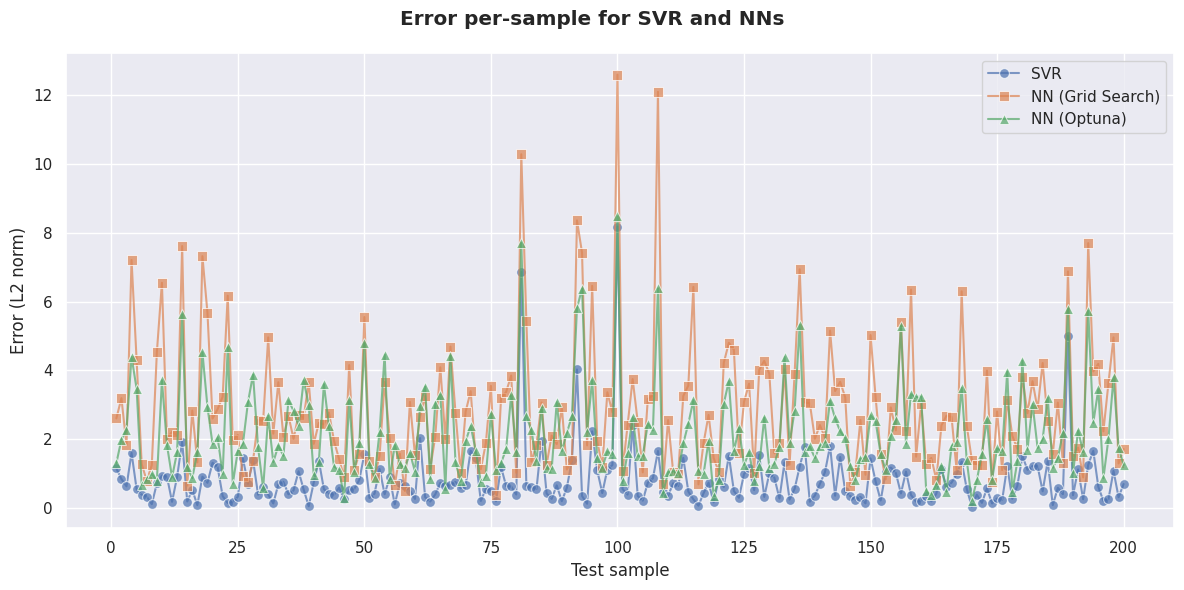

In [12]:
plt.figure(figsize=(12, 6))

sns.lineplot(
    x=range(1, y_test.shape[0] + 1),
    y=[np.linalg.norm((y_test - predictions['Support Vector Regressor'])[i, :])
       for i in range(y_test.shape[0])],
    label='SVR',
    linestyle='-',
    marker='o',
    markersize=7,
    alpha=0.7
)
sns.lineplot(
    x=range(1, y_test.shape[0] + 1),
    y=[np.linalg.norm((y_test - predictions['Neural Network (Grid Search)'])[i, :])
       for i in range(y_test.shape[0])],
    label='NN (Grid Search)',
    linestyle='-',
    marker='s',
    markersize=7,
    alpha=0.7
)
sns.lineplot(
    x=range(1, y_test.shape[0] + 1),
    y=[np.linalg.norm((y_test - predictions['Neural Network (Optuna)'])[i, :])
       for i in range(y_test.shape[0])],
    label='NN (Optuna)',
    linestyle='-',
    marker='^',
    markersize=7,
    alpha=0.7
)

plt.xlabel('Test sample')
plt.ylabel('Error (L2 norm)')
plt.suptitle(f'Error per-sample for SVR and NNs', fontweight='bold')
plt.tight_layout()
plt.legend()
save_plot(plt, IMAGES_DIR, f'best3_error_per_sample')
plt.show()

## 3D scatter plot

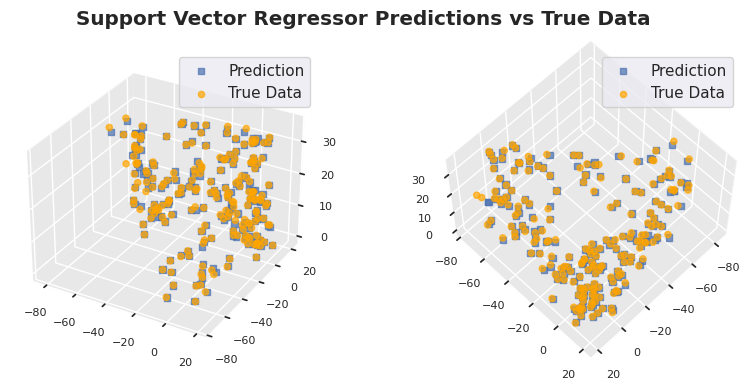

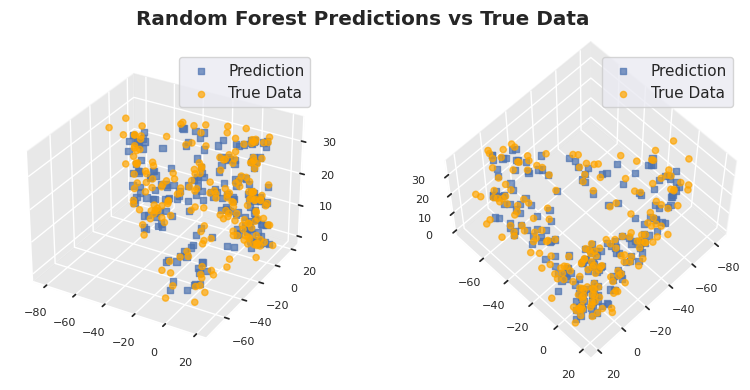

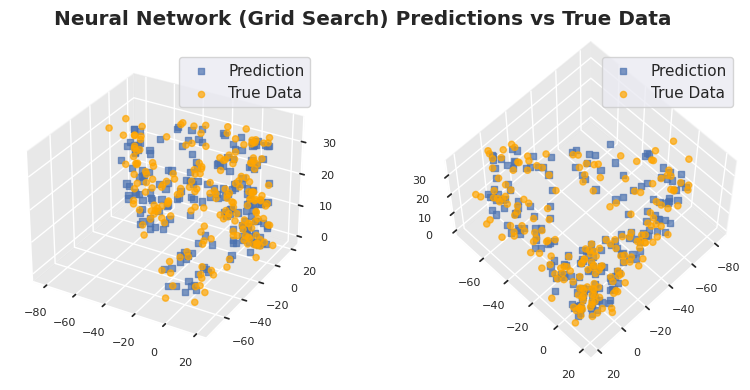

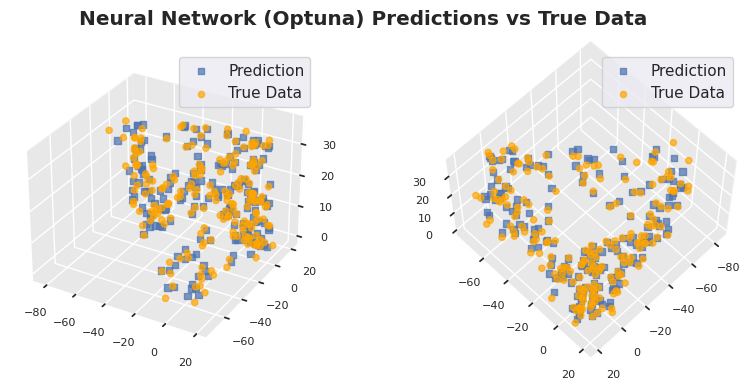

In [13]:
for model_name, prediction in predictions.items():
    fig = plt.figure(figsize=(10, 4))

    # First subplot
    ax1 = fig.add_subplot(121, projection='3d')

    # Predictions
    ax1.scatter(
        prediction[:,0], prediction[:,1], prediction[:,2],
        label='Prediction',
        marker='s',
        alpha=0.7
    )

    # True data
    ax1.scatter(
        y_test[:,0], y_test[:,1], y_test[:,2],
        label='True Data',
        marker='o',
        alpha=0.7,
        color='orange'
    )

    ax1.set_facecolor('white')
    ax1.xaxis.pane.fill = True
    ax1.yaxis.pane.fill = True
    ax1.zaxis.pane.fill = True
    ax1.xaxis.pane.set_facecolor('lightgrey')
    ax1.yaxis.pane.set_facecolor('lightgrey')
    ax1.zaxis.pane.set_facecolor('lightgrey')
    ax1.legend()
    for label in (ax1.get_xticklabels() + ax1.get_yticklabels() + ax1.get_zticklabels()):
        label.set_fontsize(8)

    # Second subplot: another view of the same plot
    ax2 = fig.add_subplot(122, projection='3d')

    # Predictions
    ax2.scatter(
        prediction[:,0], prediction[:,1], prediction[:,2],
        label='Prediction',
        marker='s',
        alpha=0.7
    )

    # True data
    ax2.scatter(
        y_test[:,0], y_test[:,1], y_test[:,2],
        label='True Data',
        marker='o',
        alpha=0.7,
        color='orange'
    )

    ax2.view_init(elev=60, azim=45)
    ax2.set_facecolor('white')
    ax2.xaxis.pane.fill = True
    ax2.yaxis.pane.fill = True
    ax2.zaxis.pane.fill = True
    ax2.xaxis.pane.set_facecolor('lightgrey')
    ax2.yaxis.pane.set_facecolor('lightgrey')
    ax2.zaxis.pane.set_facecolor('lightgrey')
    ax2.legend()
    for label in (ax2.get_xticklabels() + ax2.get_yticklabels() + ax2.get_zticklabels()):
        label.set_fontsize(8)

    plt.suptitle(f'{model_name} Predictions vs True Data', fontweight='bold')
    plt.subplots_adjust(wspace=0.2)
    model_acronym = models[model_name]['acronym']
    save_plot(plt, IMAGES_DIR, f'{model_acronym}_3d_scatterplot')
    plt.show()

In [14]:
for model_name, inner_dict in models.items():
  y_result = predictions[model_name]
  mee_ensemble = mean_euclidean_error(y_test, y_result)
  r2_ensemble = multidim_r2(y_test, y_result)
  rmse_ensemble = root_mean_squared_error(y_test, y_result)
  mse_ensemble = mean_squared_error(y_test, y_result)

  print(f'Ensemble MEE {model_name}:', mee_ensemble)
  print(f'Ensemble R2 {model_name}:', r2_ensemble)
  print(f'Ensemble RMSE {model_name}:', rmse_ensemble)
  print(f'Ensemble MSE {model_name}:', mse_ensemble)

Ensemble MEE Support Vector Regressor: 0.8133348067604963
Ensemble R2 Support Vector Regressor: 0.9983092218113913
Ensemble RMSE Support Vector Regressor: 0.7056264609643093
Ensemble MSE Support Vector Regressor: 0.4979087024130159
Ensemble MEE Random Forest: 2.489023638159878
Ensemble R2 Random Forest: 0.988005463732538
Ensemble RMSE Random Forest: 1.8680328966735462
Ensemble MSE Random Forest: 3.4895469030545594
Ensemble MEE Neural Network (Grid Search): 2.8792718619523976
Ensemble R2 Neural Network (Grid Search): 0.9854857864231975
Ensemble RMSE Neural Network (Grid Search): 2.0164539170830613
Ensemble MSE Neural Network (Grid Search): 4.066086399719621
Ensemble MEE Neural Network (Optuna): 2.1617355779326606
Ensemble R2 Neural Network (Optuna): 0.9928586087949914
Ensemble RMSE Neural Network (Optuna): 1.4830960804475801
Ensemble MSE Neural Network (Optuna): 2.1995739838389747


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

res_path = '/content/drive/My Drive/machine-learning-project/src/cup2023/grid_search_SVR_results.csv'
results = pd.read_csv(res_path)

def generate_heatmap_for_kernel(kernel_type, param_x, param_y):
    kernel_results = results[results['param_svr__estimator__kernel'] == kernel_type]

    grouped_results = kernel_results.groupby(['param_svr__estimator__' + param_x, 'param_svr__estimator__' + param_y])
    mean_scores = np.abs(grouped_results['mean_test_MEE'].mean().unstack())

    plt.figure(figsize=(10, 8))
    sns.heatmap(mean_scores, annot=True, cmap='magma_r')
    plt.title(f'Heatmap of Mean Test MEE for {kernel_type.capitalize()} Kernel ({param_x} vs {param_y})')
    plt.xlabel(param_y.capitalize())
    plt.ylabel(param_x.capitalize())
    plt.show()

In [31]:
param_grid = [
    {
        'svr__estimator__kernel': ['linear'],
        'svr__estimator__C': [0.1, 1, 10, 100],
        'svr__estimator__epsilon': [0.01, 0.1, 1]
    },
    {
        'svr__estimator__kernel': ['rbf'],
        'svr__estimator__C': [0.1, 1, 10, 100],
        'svr__estimator__gamma': [0.1, 0.01, 0.001],
        'svr__estimator__epsilon': [0.01, 0.1, 1]
    },
    {
        'svr__estimator__kernel': ['poly'],
        'svr__estimator__C': [0.1, 1, 10, 100],
        'svr__estimator__degree': [2, 3, 4],
        'svr__estimator__gamma': [0.1, 0.01, 0.001],
        'svr__estimator__coef0': [0, 1, 2],
        'svr__estimator__epsilon': [0.01, 0.1, 1]
    },
    {
        'svr__estimator__kernel': ['sigmoid'],
        'svr__estimator__C': [0.1, 1, 10, 100],
        'svr__estimator__gamma': [0.1, 0.01, 0.001],
        'svr__estimator__coef0': [0, 1, 2],
        'svr__estimator__epsilon': [0.01, 0.1, 1]
    }
]

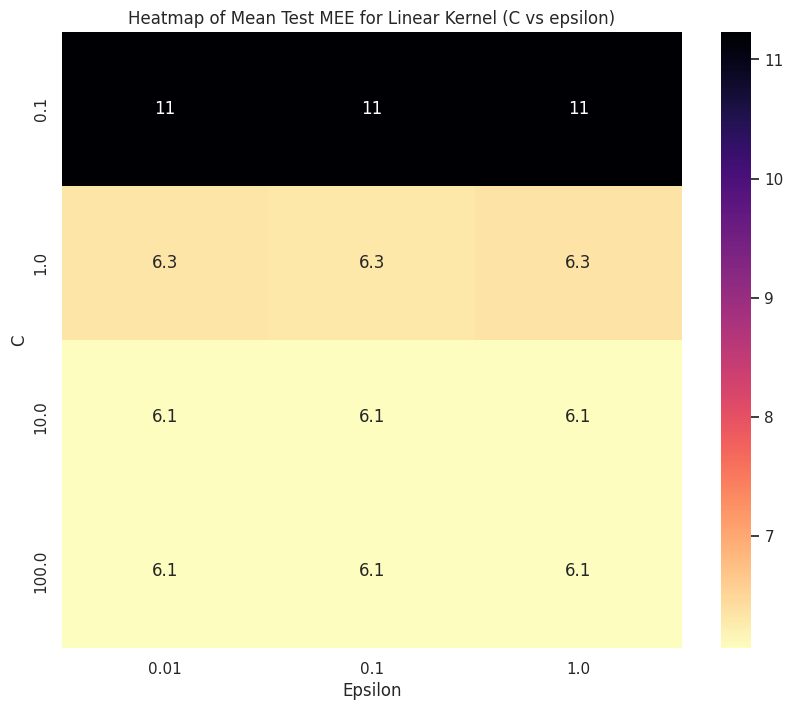

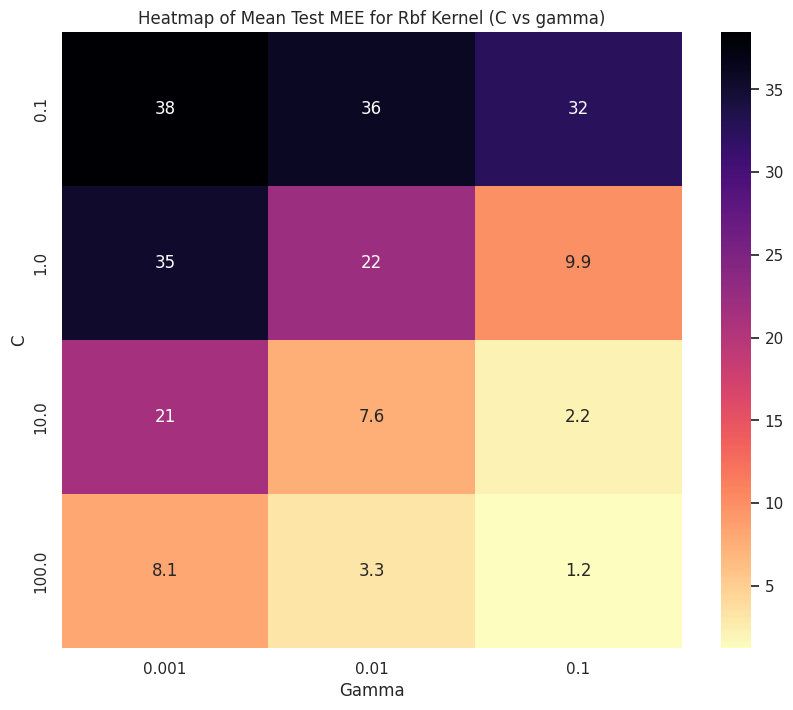

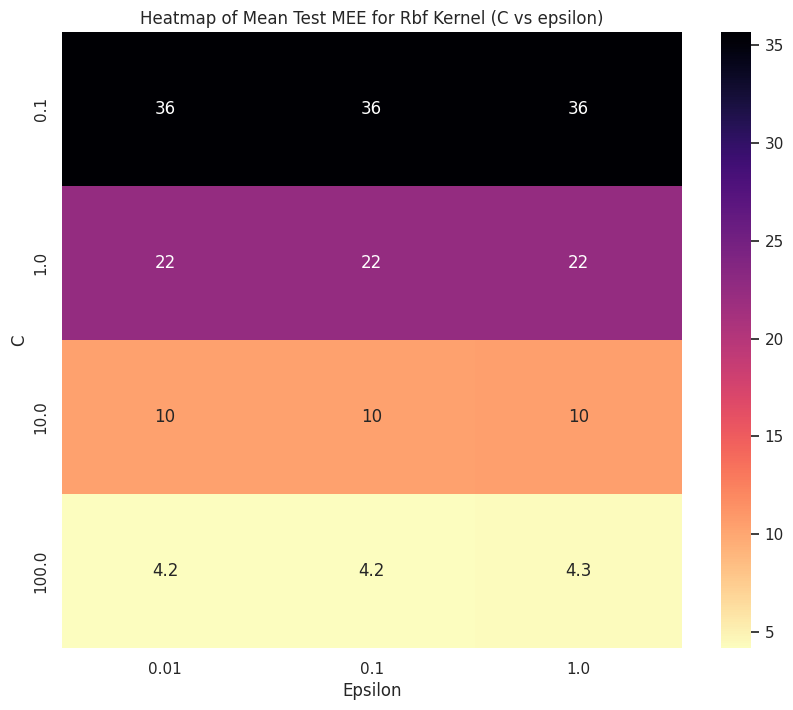

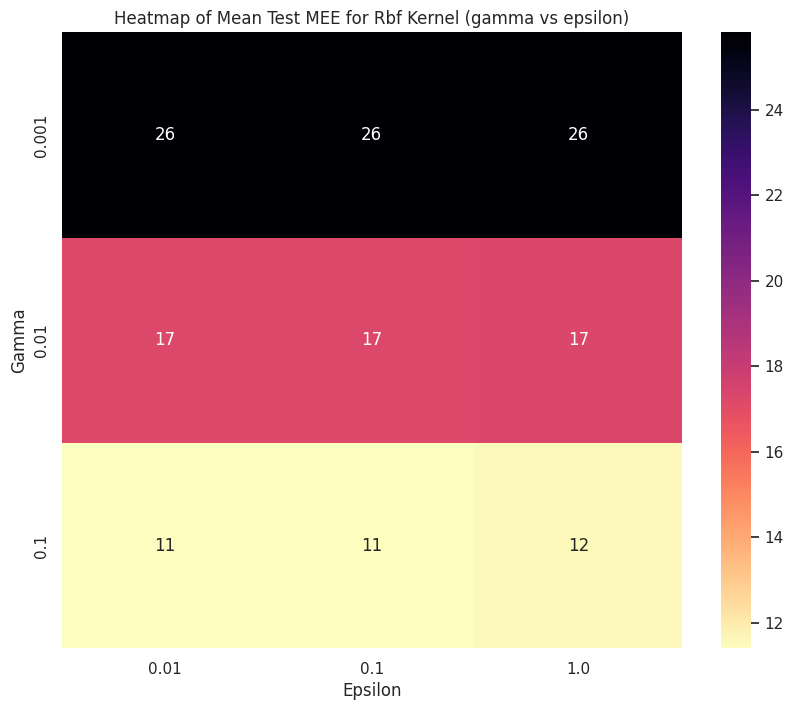

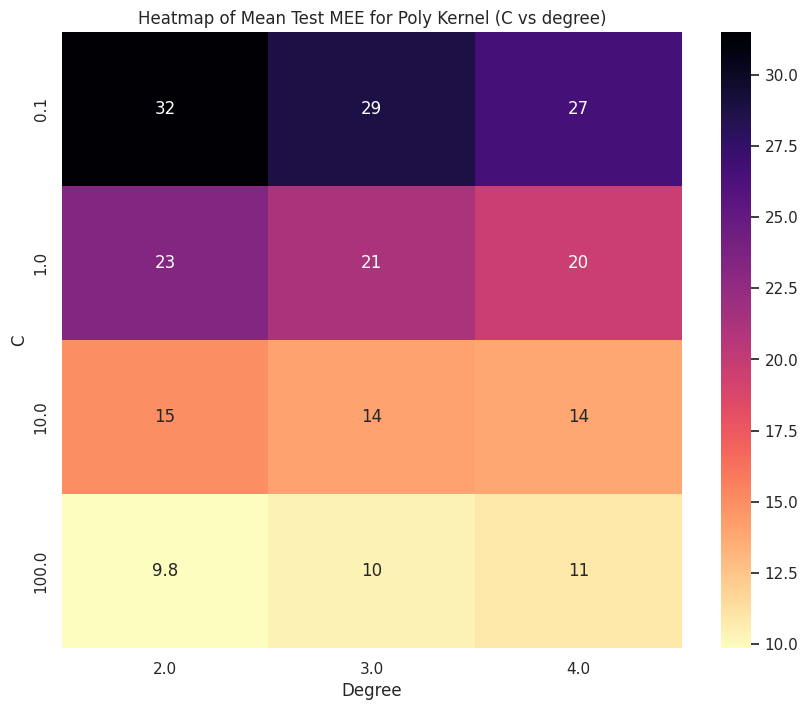

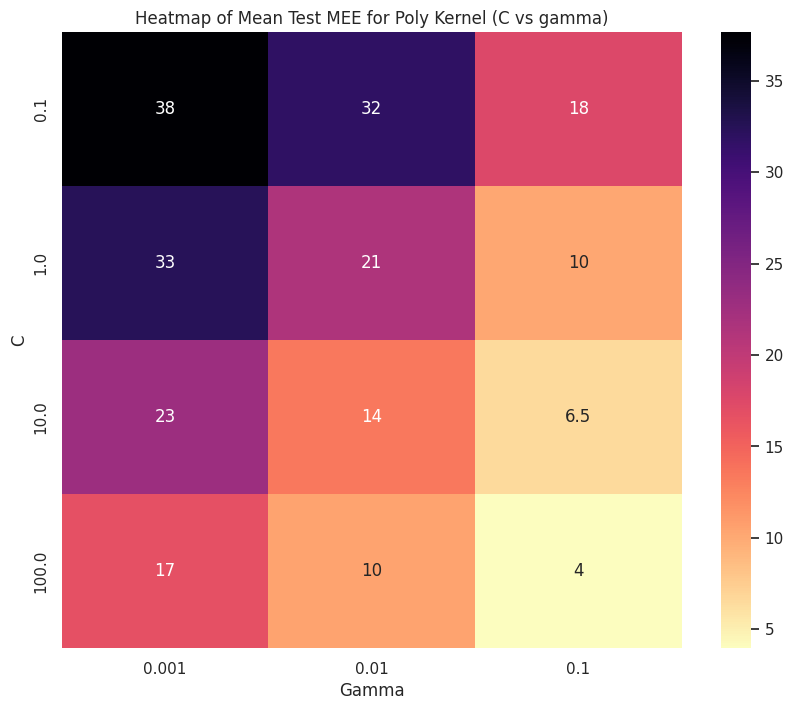

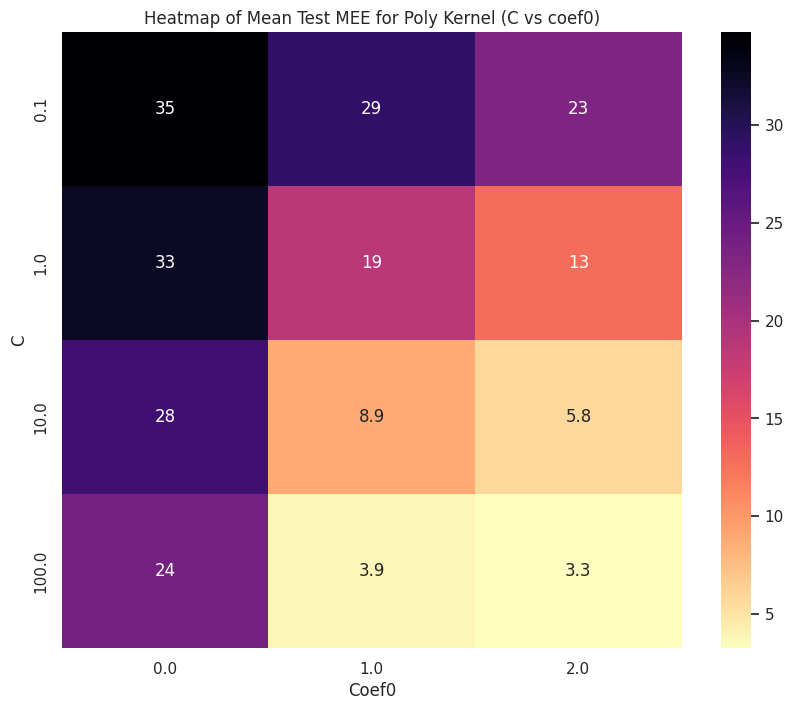

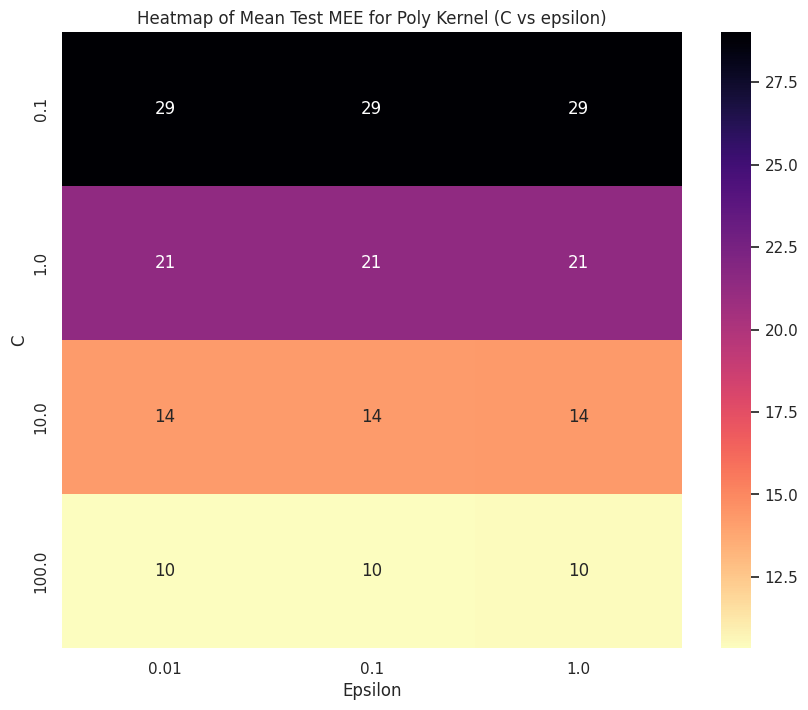

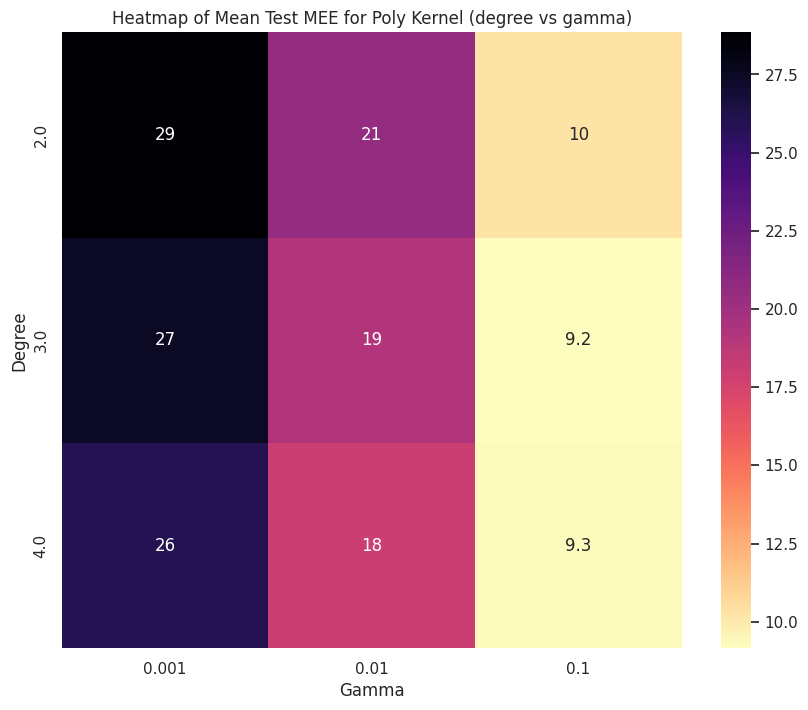

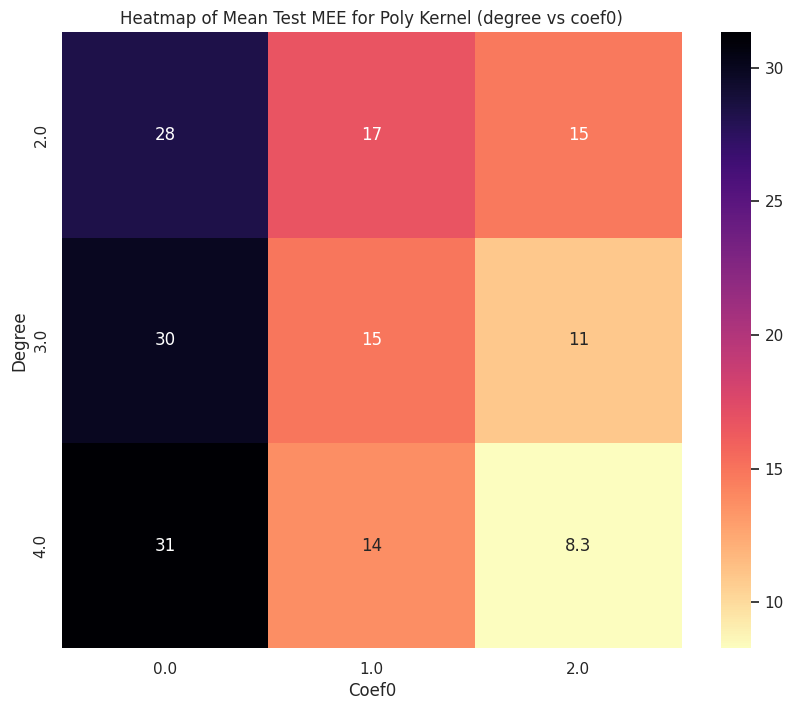

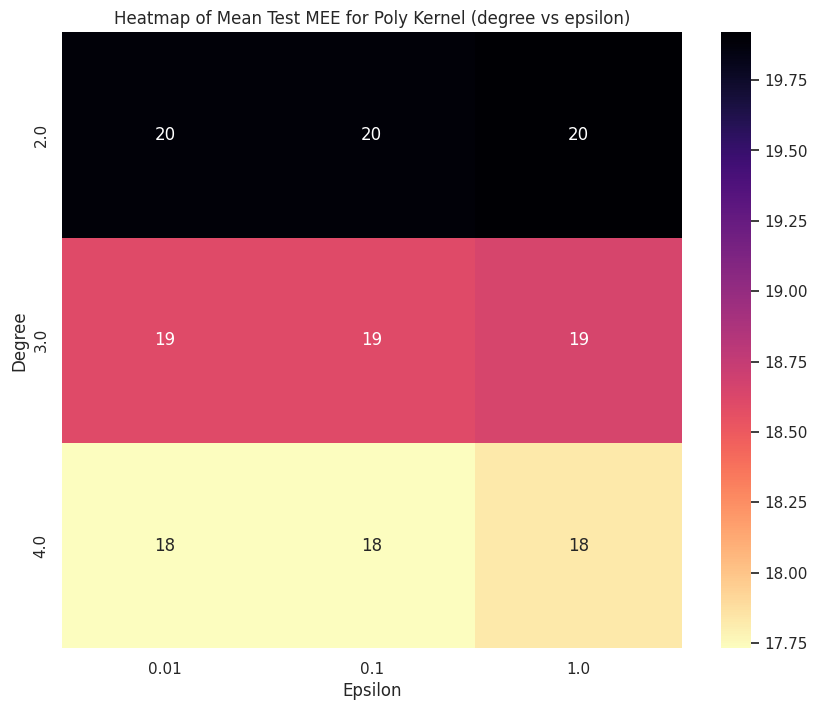

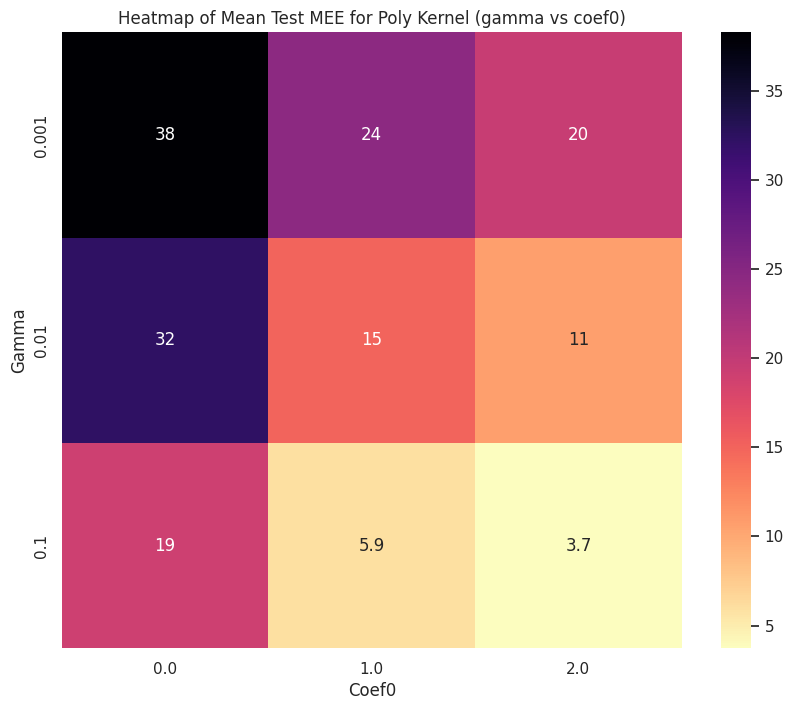

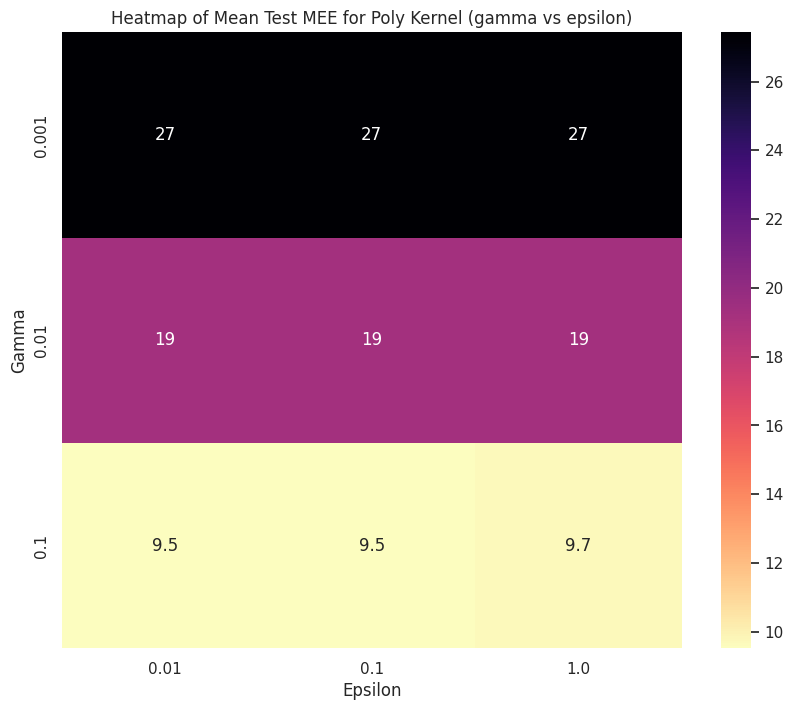

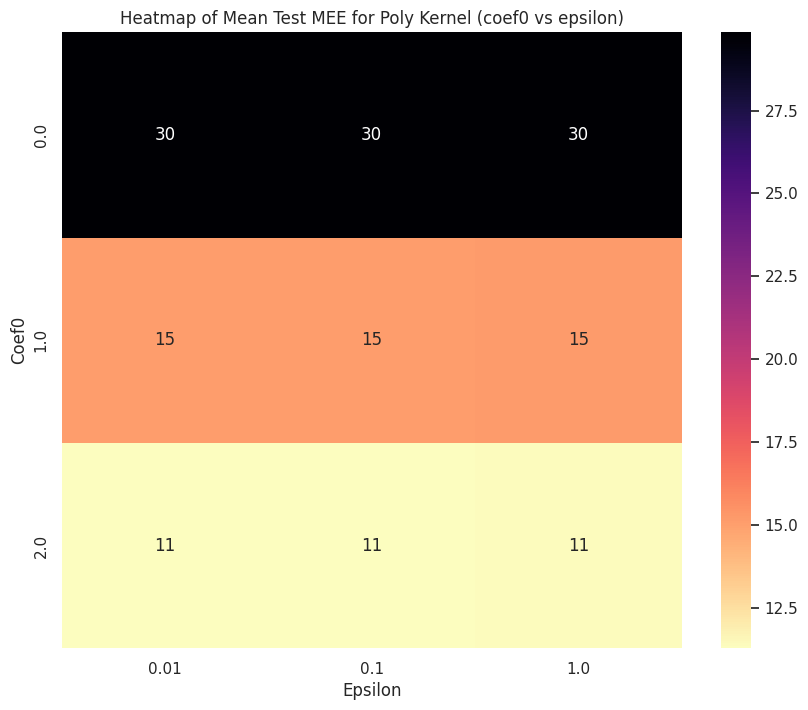

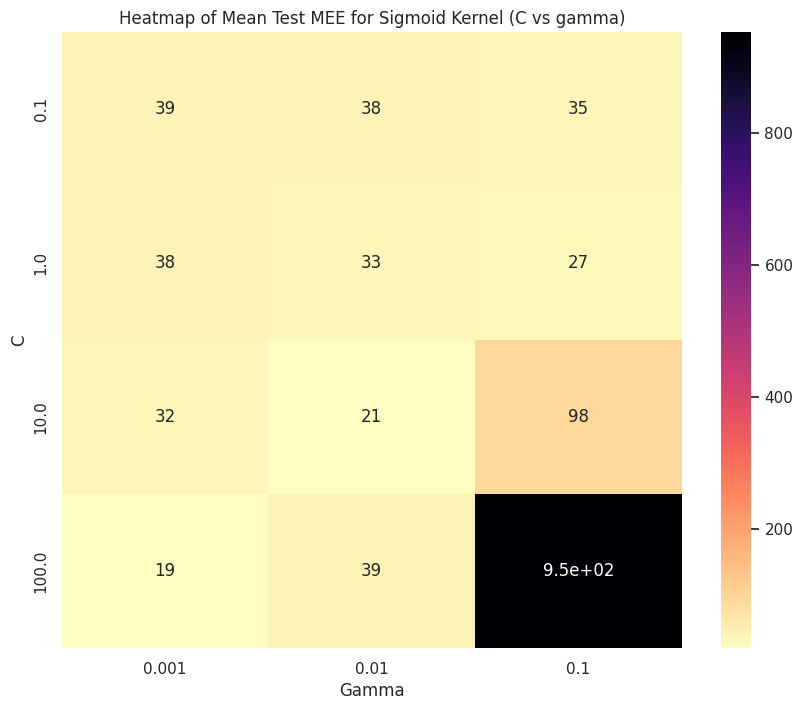

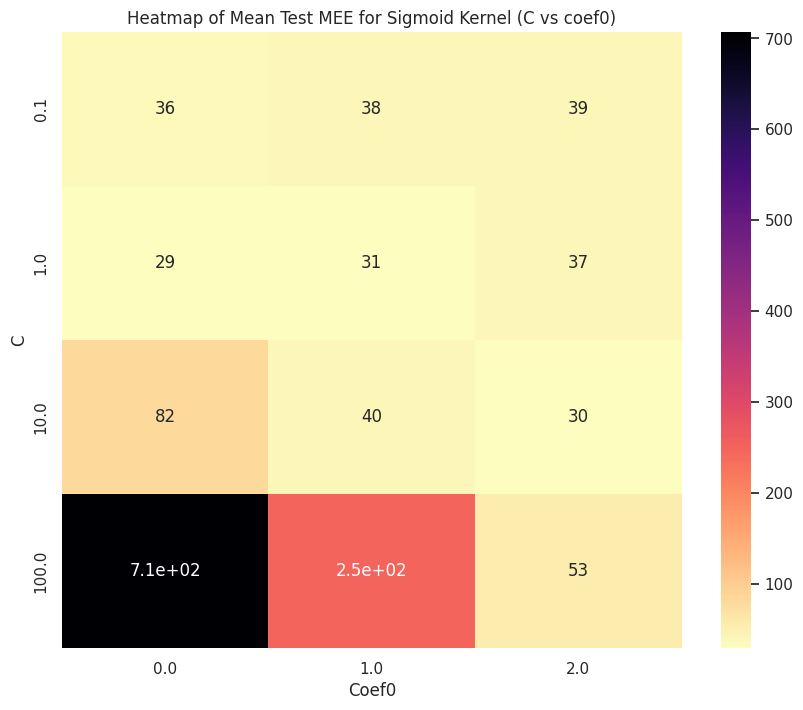

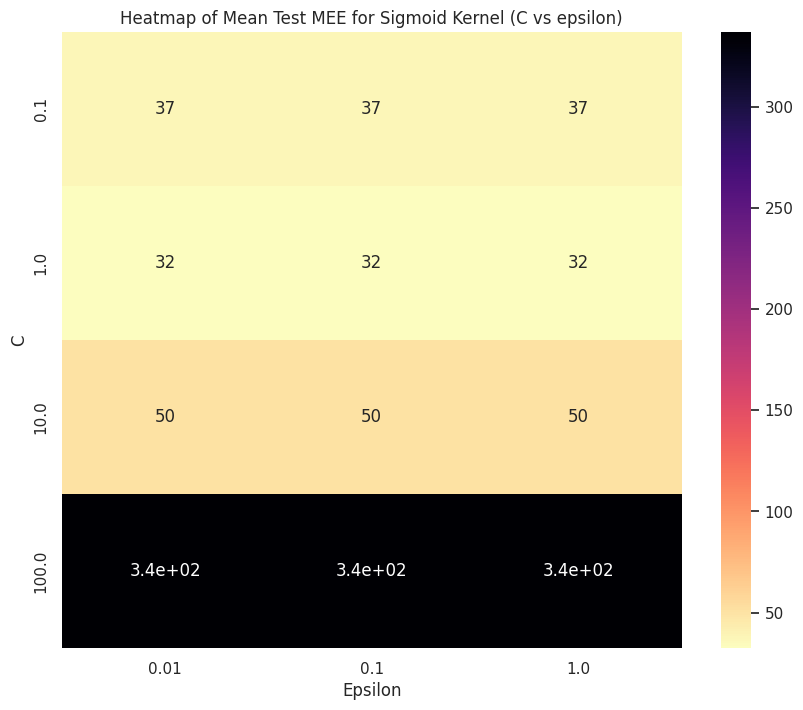

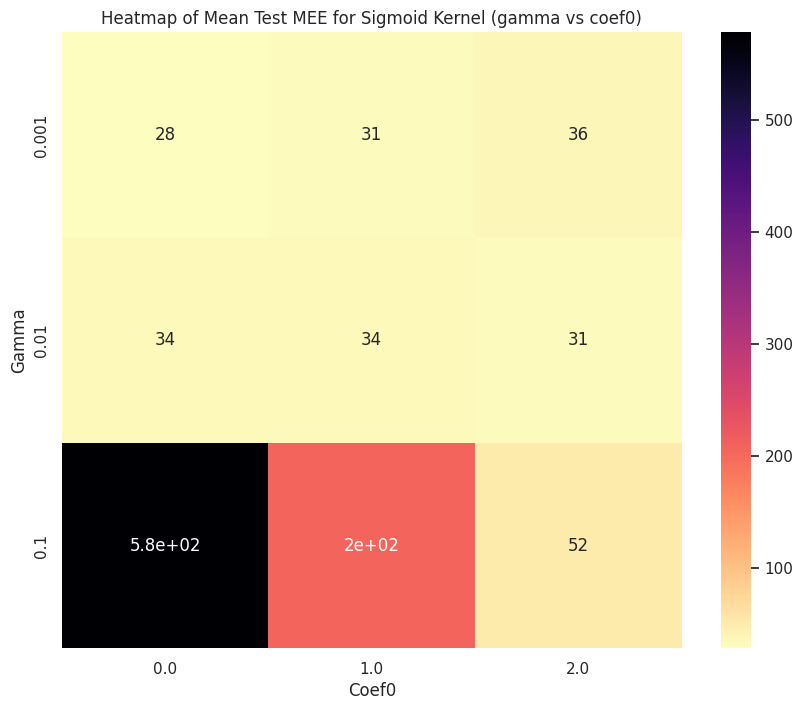

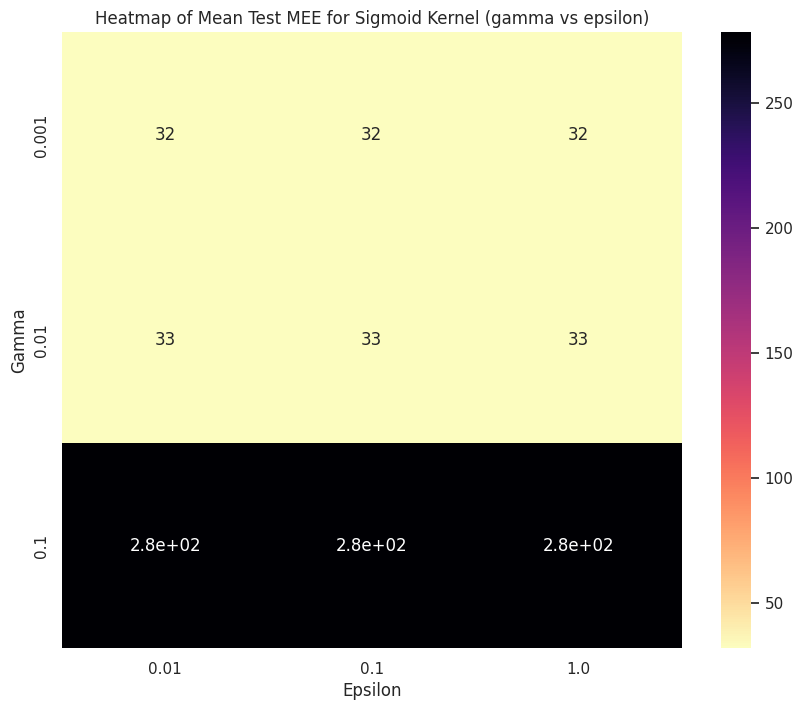

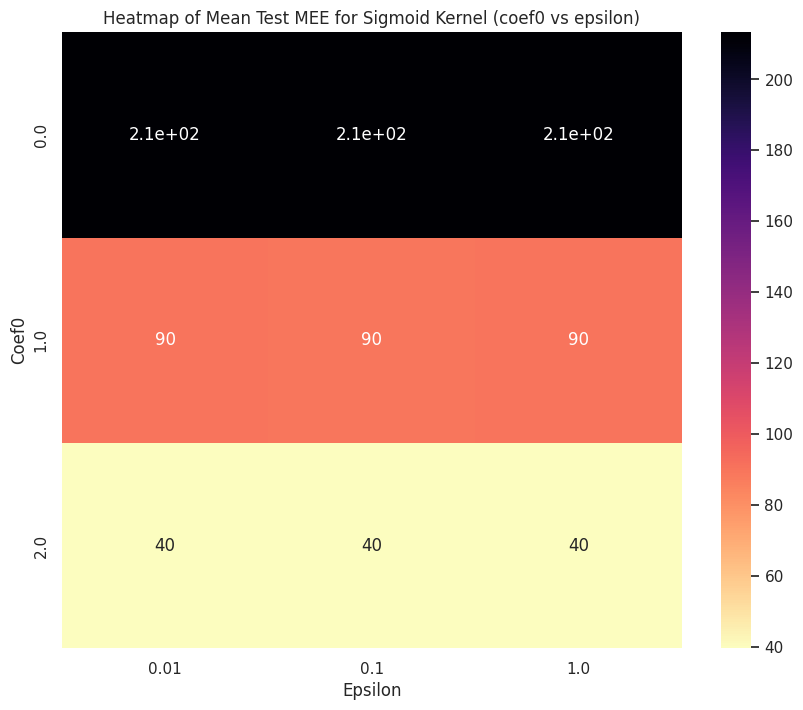

In [32]:
from itertools import combinations

for params in param_grid:
    kernel = params['svr__estimator__kernel'][0] 
    param_names = [key.replace('svr__estimator__', '') for key in params.keys() if key != 'svr__estimator__kernel']

    for param1, param2 in combinations(param_names, 2):
        generate_heatmap_for_kernel(kernel, param1, param2)